<a href="https://colab.research.google.com/github/ovbystrova/dpl/blob/master/notebooks/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://github.com/williamSYSU/TextGAN-PyTorch
# https://github.com/DSleeps/Text-GAN
# https://github.com/rtst777/TextGAN
# https://github.com/MuratArda-coder/GAN-Text-Generation

In [0]:
# TODO Разнести по models

In [1]:
!git clone https://github.com/ovbystrova/dpl.git
import os
os.chdir('/content/dpl')

Cloning into 'dpl'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 197 (delta 5), reused 0 (delta 0), pack-reused 185
Receiving objects: 100% (197/197), 228.88 MiB | 28.03 MiB/s, done.
Resolving deltas: 100% (106/106), done.
Checking out files: 100% (28/28), done.


In [0]:
%%capture
!pip install tokenizers

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.datasets import WikiText2
from torchtext import data

import matplotlib.pyplot as plt
import numpy as np
import math
from collections import namedtuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
from modules.sntpiece_tokenization import make_tokenizer, clean_data, special_tokens
from tqdm import tqdm

def clean_tqdm():
    for instance in list(tqdm._instances): 
        tqdm._decr_instances(instance)

for e in tqdm([1,2,3]):
    pass

100%|██████████| 3/3 [00:00<00:00, 6043.67it/s]


In [0]:
LM_PATH = '/content/dpl/data/model (1)'
BATCH_SIZE = 64
SEQ_LENGTH = 40

#Data

In [0]:
%%capture
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip 'wikitext-2-v1.zip'

In [8]:
tokenizer = make_tokenizer()
tokenizer

Tokenizer(vocabulary_size=30000, model=SentencePieceBPE, unk_token=<unk>, replacement=▁, add_prefix_space=True, dropout=None)

In [0]:
def tokenize(text, tokenizer=tokenizer):
    text = clean_data(text)
    text = special_tokens(text)
    return tokenizer.encode(text).tokens

In [0]:
%%capture
TEXT = data.Field(sequential=True, 
                  include_lengths=False, 
                  batch_first=True, 
                  tokenize=tokenize,
                  lower=True, 
                  pad_first=True, 
                  )

train, valid, test = WikiText2.splits(TEXT)

TEXT.build_vocab(train, valid, unk_init = torch.Tensor.normal_, vectors='glove.6B.200d')
vocab = TEXT.vocab

In [11]:
print('Vocab size:', len(TEXT.vocab.itos))
TEXT.vocab.itos[:10]

Vocab size: 22734


['<unk>', '<pad>', '▁', '▁the', '<eos>', '<start>', '▁,', '▁of', '▁and', '▁in']

# Model

## Generator

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        self.rnn = nn.LSTM(input_size=embed_dim,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):
        
        x = batch.text.T if hasattr(batch, 'text') else batch #    
        x = self.embedding(x)  # (batch_size, sequence_length, embed_dim)           
        x, _ = self.rnn(x)  # (batch_size, sequence length, hidden_size)
        x = self.fc(x)  # (batch_size, sequence_length, vocab_size)
        x = F.gumbel_softmax(x, dim=-1)
        return x  # (batch_size, sequence_length, vocab_size)

In [24]:
train_iterator_g, valid_iterator_g, test_iterator_g = data.BPTTIterator.splits(
    (train, valid, test),
    batch_size=BATCH_SIZE,
    bptt_len=SEQ_LENGTH,
    device=device,
    repeat=False, 
    shuffle=True)

generator = MyModel(vocab_size=len(TEXT.vocab.itos),
                embed_dim=200,
                hidden_size=128,
               )
generator.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=1)
criterion.to(device)

CrossEntropyLoss()

In [14]:
for el in train_iterator_g:
    with torch.no_grad():
        x = el.text
        y = el.target.T
        print('X and Y sizes', x.size(), y.size())
        preds = generator(el)
        print('Generator pred size: ', preds.size())
        loss = criterion(preds.transpose(1,2), y)
        print('Loss whole: ', loss)
    break

X and Y sizes torch.Size([40, 64]) torch.Size([64, 40])
Generator pred size:  torch.Size([64, 40, 22734])
Loss whole:  tensor(10.0316, device='cuda:0')


In [15]:
# poorly pretrained generator
generator.load_state_dict(torch.load(LM_PATH))

<All keys matched successfully>

## Discriminator

### from RelGAN

https://github.com/williamSYSU/TextGAN-PyTorch

In [0]:
class RelGAN_D(nn.Module):
    def __init__(self, embed_dim, max_seq_len, num_rep, vocab_size, padding_idx, gpu=False, dropout=0.25):
        super(RelGAN_D, self).__init__()

        self.embed_dim = embed_dim
        self.max_seq_len = max_seq_len
        self.feature_dim = sum(dis_num_filters)
        self.emb_dim_single = int(embed_dim / num_rep)

        self.embeddings = nn.Linear(vocab_size, embed_dim, bias=False)

        self.convs = nn.ModuleList([
            nn.Conv2d(1, n, (f, self.emb_dim_single), stride=(1, self.emb_dim_single)) for (n, f) in
            zip(dis_num_filters, dis_filter_sizes)
        ])

        self.highway = nn.Linear(self.feature_dim, self.feature_dim)
        self.feature2out = nn.Linear(self.feature_dim, 100)
        self.out2logits = nn.Linear(100, 1)
        self.dropout = nn.Dropout(dropout)

        self.init_params()

    
    def init_params(self):
        for param in self.parameters():
            if param.requires_grad and len(param.shape) > 0:
                stddev = 1 / math.sqrt(param.shape[0])
                if cfg.dis_init == 'uniform':
                    torch.nn.init.uniform_(param, a=-0.05, b=0.05)
                elif cfg.dis_init == 'normal':
                    torch.nn.init.normal_(param, std=stddev)
    
    def forward(self, inp):
        """
        Get logits of discriminator
        :param inp: batch_size * seq_len * vocab_size
        :return logits: [batch_size * num_rep] (1-D tensor)
        """

        emb = self.embeddings(inp).unsqueeze(1)  # batch_size * 1 * max_seq_len * embed_dim
        cons = [F.relu(conv(emb), inplace=False) for conv in self.convs]  # [batch_size * num_filter * (seq_len-k_h+1) * num_rep]
        pools = [F.max_pool2d(con, (con.size(2), 1)).squeeze(2) for con in cons]  # [batch_size * num_filter * num_rep]
        pred = torch.cat(pools, 1)
        pred = pred.permute(0, 2, 1).contiguous().view(-1, self.feature_dim)  # (batch_size * num_rep) * feature_dim
        highway = self.highway(pred)
        pred = torch.sigmoid(highway) * F.relu(highway,  inplace=False) + (1. - torch.sigmoid(highway)) * pred  # highway

        pred = self.feature2out(self.dropout(pred))
        logits = self.out2logits(pred).squeeze(1)  # [batch_size * num_rep]

        return logits # batch_size

In [0]:
# Iterators for dicriminator
train_iterator_d, valid_iterator_d, test_iterator_d = data.BPTTIterator.splits(
    (train, valid, test),
    batch_size=BATCH_SIZE,
    bptt_len=SEQ_LENGTH,
    device=device,
    repeat=False, 
    shuffle=True)


dis_filter_sizes = [2, 3, 4]
dis_num_filters = [300, 300, 300]
cfg = namedtuple('cfg', ['dis_init'])
cfg.dis_init='uniform'

discriminator = RelGAN_D(embed_dim=200,
                         max_seq_len=SEQ_LENGTH+10,
                         num_rep=1,
                         vocab_size=len(TEXT.vocab),
                         padding_idx=TEXT.vocab.stoi['<pad>'],
                         gpu=True)
discriminator.to(device);

In [0]:
def calculate_loss(d_out_real, d_out_fake):
    """
    Calculates resgan loss
    more loss functions here: https://github.com/williamSYSU/TextGAN-PyTorch/blob/master/utils/helpers.py
    """
    bce_loss = nn.BCEWithLogitsLoss().to(device)
    d_loss = bce_loss(d_out_real - d_out_fake, torch.ones_like(d_out_real).to(device))
    g_loss = bce_loss(d_out_fake - d_out_real, torch.ones_like(d_out_fake).to(device))
    return g_loss, d_loss

In [26]:
for el in train_iterator_d:
    with torch.no_grad():
        x = el.text.T
        
        x_gen = generator(el)
        print('X generated size: ', x_gen.size())

        x_dis = F.one_hot(x, len(TEXT.vocab)).float()
        print('X real size: ', x_dis.size())
        # If not works then loop for x in x_dis and every one to float

        out_fake = discriminator(x_gen)
        out_real = discriminator(x_dis)
        print('Discriminator fake and real sizes: ', out_fake.size(), out_real.size())
        # print(out_fake, out_real)

        d_loss, g_loss = calculate_loss(out_real, out_fake)
        print('Discriminator loss: ', d_loss)
        print('Generator loss: ', g_loss)
        break

X generated size:  torch.Size([64, 40, 22734])
X real size:  torch.Size([64, 40, 22734])
Discriminator fake and real sizes:  torch.Size([64]) torch.Size([64])
Discriminator loss:  tensor(0.6950, device='cuda:0')
Generator loss:  tensor(0.6913, device='cuda:0')


### from LeakGAN

In [0]:
## Will be here in near future

### from me

In [0]:
## And here

# GAN stuff with instructor

In [0]:
# https://github.com/williamSYSU/TextGAN-PyTorch

class RelGANInstructor:
    def __init__(self, generator, discriminator):
        super(RelGANInstructor, self).__init__()

        self.gen = generator
        self.dis = discriminator
        self.n_epochs = 10

        # Optimizer
        self.gen_adv_opt = optim.Adam(self.gen.parameters(), lr=1e-3)
        self.dis_opt = optim.Adam(self.dis.parameters(), lr=1e-6)

        # Iterators
        self.train_data_g = train_iterator_g 
        self.test_data_g = test_iterator_g
        self.valid_data_g = valid_iterator_g
        self.train_data_d = train_iterator_d 
        self.test_data_d = test_iterator_d
        self.valid_data_d = valid_iterator_d

        # Dicts
        self.word2idx_dict = TEXT.vocab.stoi
        self.idx2word_dict = TEXT.vocab.itos

        self.dis_criterion = nn.CrossEntropyLoss()

        # Losses
        self.dis_losses_train = []
        self.dis_losses_valid = []
        self.gen_losses_train = []
        self.gen_losses_valid = []

    
    def _run(self):
        progress = tqdm(range(self.n_epochs))
        for adv_epoch in progress:
            g_loss = self.adv_train_generator()  # Generator
            d_loss = self.adv_train_discriminator()  # Discriminator
                      
            g_loss_valid, d_loss_valid = self._test()
            
            # progress.set_description(
            #     'g_loss: %.4f, d_loss: %.4f, g_loss_valid: %.4f, d_loss_valid: %.4f' % (g_loss, d_loss, g_loss_valid, d_loss_valid))
            
            print()
            print('g_loss: %.4f, d_loss: %.4f, g_loss_valid: %.4f, d_loss_valid: %.4f' % (g_loss, d_loss, g_loss_valid, d_loss_valid))


    def _test(self):
        g_loss_total = 0
        d_loss_total = 0
        for batch in zip(valid_iterator_g, valid_iterator_d):
            real_samples = batch[1].text.T
            gen_samples = batch[0].text.T
            gen_samples = self.gen(gen_samples)

            real_samples = F.one_hot(real_samples, len(self.word2idx_dict)).float()

            d_out_real = self.dis(real_samples)
            d_out_fake = self.dis(gen_samples)

            g_loss, d_loss = calculate_loss(d_out_real=d_out_real, d_out_fake=d_out_fake)

            self.gen_losses_valid.append(g_loss.item())
            self.dis_losses_valid.append(d_loss.item())

            g_loss_total += g_loss.item()
            d_loss_total += d_loss.item() 

        return g_loss_total / len(valid_iterator_g), d_loss_total / len(valid_iterator_d)


    def adv_train_generator(self):
        loss = 0
        for batch in zip(train_iterator_g, train_iterator_d):
            real_samples = batch[1].text.T
            gen_samples = batch[0].text.T
            gen_samples = self.gen(gen_samples)

            real_samples = F.one_hot(real_samples, len(self.word2idx_dict)).float()

            d_out_real = self.dis(real_samples)
            d_out_fake = self.dis(gen_samples)

            g_loss, _ = calculate_loss(d_out_real=d_out_real, d_out_fake=d_out_fake)

            self.optimize(self.gen_adv_opt, g_loss, self.gen)
            self.gen_losses_train.append(g_loss.item())
            loss += g_loss.item()

        return loss / len(train_iterator_g)


    def adv_train_discriminator(self):
        loss = 0
        for batch in zip(train_iterator_g, train_iterator_d):
            real_samples = batch[1].text.T
            gen_samples = batch[0].text.T
            gen_samples = self.gen(gen_samples)

            real_samples = F.one_hot(real_samples, len(self.word2idx_dict)).float()

            d_out_real = self.dis(real_samples)
            d_out_fake = self.dis(gen_samples)

            _, d_loss = calculate_loss(d_out_real=d_out_real, d_out_fake=d_out_fake)

            self.optimize(self.dis_opt, d_loss, self.dis)
            self.dis_losses_train.append(d_loss.item())
            loss += d_loss.item()

        return loss / len(train_iterator_d)


    @staticmethod
    def optimize(opt, loss, model=None, retain_graph=False):
        opt.zero_grad()
        loss.backward(retain_graph=retain_graph)
        if model is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        opt.step()

In [0]:
instructor = RelGANInstructor(generator=generator, discriminator=discriminator)

In [29]:
clean_tqdm()
instructor._run()

 10%|█         | 1/10 [02:15<20:15, 135.11s/it]


g_loss: 0.6884, d_loss: 0.6717, g_loss_valid: 0.7533, d_loss_valid: 0.6365


 20%|██        | 2/10 [04:30<18:00, 135.08s/it]


g_loss: 0.7422, d_loss: 0.5800, g_loss_valid: 0.9300, d_loss_valid: 0.5019


 30%|███       | 3/10 [06:45<15:45, 135.06s/it]


g_loss: 0.7737, d_loss: 0.5708, g_loss_valid: 0.9598, d_loss_valid: 0.4833


 40%|████      | 4/10 [09:00<13:30, 135.02s/it]


g_loss: 0.8101, d_loss: 0.5472, g_loss_valid: 0.9988, d_loss_valid: 0.4603


 50%|█████     | 5/10 [11:14<11:14, 134.96s/it]


g_loss: 0.9532, d_loss: 0.3860, g_loss_valid: 1.4104, d_loss_valid: 0.2814


 60%|██████    | 6/10 [13:29<08:59, 134.89s/it]


g_loss: 1.1813, d_loss: 0.2613, g_loss_valid: 1.8977, d_loss_valid: 0.1648


 70%|███████   | 7/10 [15:44<06:44, 134.90s/it]


g_loss: 1.7285, d_loss: 0.1542, g_loss_valid: 2.4739, d_loss_valid: 0.0911


 80%|████████  | 8/10 [17:59<04:29, 134.99s/it]


g_loss: 1.6022, d_loss: 0.1378, g_loss_valid: 2.7564, d_loss_valid: 0.0701


 90%|█████████ | 9/10 [20:14<02:15, 135.04s/it]


g_loss: 2.6338, d_loss: 0.0507, g_loss_valid: 3.6623, d_loss_valid: 0.0288


100%|██████████| 10/10 [22:29<00:00, 134.99s/it]


g_loss: 3.1052, d_loss: 0.0586, g_loss_valid: 3.9453, d_loss_valid: 0.0236


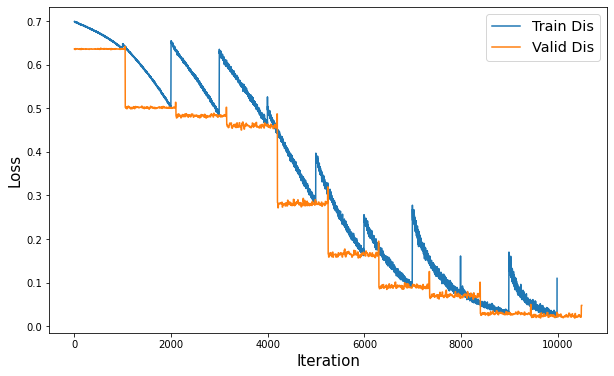

In [30]:
new_val = [el for el in instructor.dis_losses_valid for i in range(10)]
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(instructor.dis_losses_train)), instructor.dis_losses_train, label='Train Dis')
plt.plot(np.arange(len(new_val)), new_val, label='Valid Dis')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

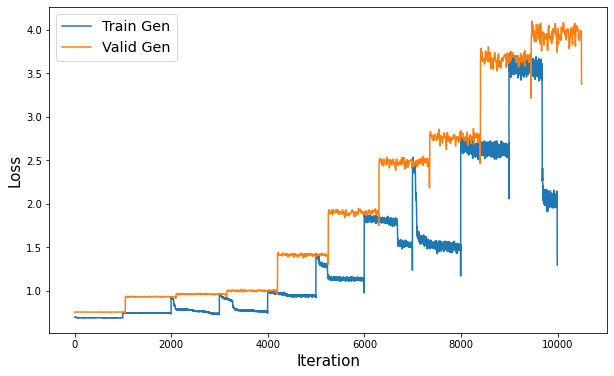

In [31]:
plt.figure(figsize=(10,6))
new_val = [el for el in instructor.gen_losses_valid for i in range(10)]
plt.plot(np.arange(len(instructor.gen_losses_train)), instructor.gen_losses_train, label='Train Gen')
plt.plot(np.arange(len(new_val)), new_val, label='Valid Gen')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()